In [22]:
# Importing libraries

import os
import numpy as np
import shutil 
import torch 
import torchvision
import random

from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

torch.manual_seed(0)

print("Using pyTorch version ", torch.__version__)

Using pyTorch version  1.6.0


In [23]:
class_names = ['normal' , 'viral' , 'covid']
root_dir = "COVID-19 Radiography Database"
source_dir = ['NORMAL','Viral Pneumonia' ,'COVID-19']

if os.path.isdir(os.path.join(root_dir , source_dir[1])):
    print("Entering")
    os.mkdir(os.path.join(root_dir ,'test'))
    os.mkdir(os.path.join(root_dir ,'validation'))
    
    for i , d in enumerate(source_dir):
        os.rename(os.path.join(root_dir , d) , os.path.join(root_dir , class_names[i]))
        
    for c in class_names:
        os.mkdir(os.path.join(root_dir , 'validation' , c))
    for c in class_names:
        os.mkdir(os.path.join(root_dir , 'test' , c))    
        
    
    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, 30)
        for image in selected_images:
            source_path = os.path.join(root_dir, c, image)
            target_path = os.path.join(root_dir, 'validation', c, image)
            shutil.move(source_path, target_path)
            
    
    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, 15)
        for image in selected_images:
            source_path = os.path.join(root_dir, c, image)
            target_path = os.path.join(root_dir, 'test', c, image)
            shutil.move(source_path, target_path)

In [3]:
class ChestXRayDataSet(torch.utils.data.Dataset):
    def __init__(self,image_dirs , transform):#transform - will be used for data augumentation
        def get_images(class_names):
            images = [x for x in os.listdir(image_dirs[class_names]) if x.lower().endswith('png')]
            print(f"Found {len(images)} {class_names}  examples")
            return images
        
        
        self.images = {}
        self.class_names = ['normal' , 'viral' , 'covid']
        
        for class_name in self.class_names:
            self.images[class_name] =  get_images(class_name)
            
        self.image_dirs = image_dirs
        self.transform  = transform
    
    def __len__(self):
        return sum([len(self.images[class_name]) for class_name in self.class_names])
    
    def __getitem__(self , index):
        class_name =  random.choice(self.class_names)
        index = index % len(self.images[class_name])
        image_name =  self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name] , image_name)
        image = Image.open(image_path).convert("RGB")
        return self.transform(image) , self.class_names.index(class_name)
        
        
        

In [4]:
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size  =  (224 , 224)),# converting into the shape that the model expects ()
    torchvision.transforms.RandomHorizontalFlip(),# this is for data augumentation
    torchvision.transforms.ToTensor(),# converting to tensor so that it can be used in computation by pytorch
    torchvision.transforms.Normalize(mean = [0.485 , 0.456 , 0.406] , std = [0.229 ,0.224 , 0.225] )
])


In [5]:
test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size  =  (224 , 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean = [0.485 , 0.456 , 0.406] , std = [0.229 ,0.224 , 0.225] )
])


validation_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size  =  (224 , 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean = [0.485 , 0.456 , 0.406] , std = [0.229 ,0.224 , 0.225] )
])


In [6]:
train_dirs = {
    'normal':'COVID-19 Radiography Database/normal',
    'viral':'COVID-19 Radiography Database/viral',
    'covid':'COVID-19 Radiography Database/covid',
}

In [7]:
train_dataset = ChestXRayDataSet(train_dirs , train_transforms)

Found 1296 normal  examples
Found 1300 viral  examples
Found 174 covid  examples


In [8]:
validation_dirs = {
    'normal':'COVID-19 Radiography Database/validation/normal',
    'viral':'COVID-19 Radiography Database/validation/viral',
    'covid':'COVID-19 Radiography Database/validation/covid',
}
validation_dataset = ChestXRayDataSet(validation_dirs ,  validation_transforms)

Found 30 normal  examples
Found 30 viral  examples
Found 30 covid  examples


In [9]:
test_dirs = {
    'normal':'COVID-19 Radiography Database/test/normal',
    'viral':'COVID-19 Radiography Database/test/viral',
    'covid':'COVID-19 Radiography Database/test/covid',
}
test_dataset = ChestXRayDataSet(test_dirs , test_transforms)

Found 15 normal  examples
Found 15 viral  examples
Found 15 covid  examples


In [10]:
batch_size = 6
dl_train = torch.utils.data.DataLoader(train_dataset , batch_size=batch_size, shuffle= True)
dl_validation = torch.utils.data.DataLoader(validation_dataset , batch_size=batch_size, shuffle= True)
dl_test = torch.utils.data.DataLoader(test_dataset , batch_size=batch_size, shuffle= True)

print("Number of training batches " , len(dl_train))
print("Number of validation batches " , len(dl_validation))
print("Number of test batches " , len(dl_test))

Number of training batches  462
Number of validation batches  15
Number of test batches  8


In [11]:
class_names = train_dataset.class_names

def show_images(images , labels , preds):
    plt.figure(figsize  = (8,4))
    for i , image in enumerate(images):
        plt.subplot(1, 6, i+1 , xticks = [] , yticks =[])
        image = image.numpy().transpose((1,2,0)) # (channel , height , width) as per renet18
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image , 0.0 , 1.0)
        plt.imshow(image)
        col = 'green' if preds[i]==labels[i] else "red"
        
        plt.xlabel(f"{class_names[int(labels[i].numpy())]}")
        plt.ylabel(f"{class_names[int(preds[i].numpy())]}" , color = col)
    plt.tight_layout()
    plt.show()

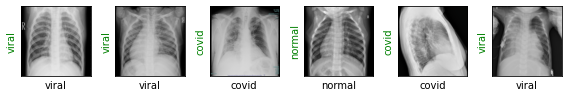

In [12]:
images , labels = next(iter(dl_train)) # this will iterate over the dl_train and get the next batch
show_images(images , labels , labels)
                       

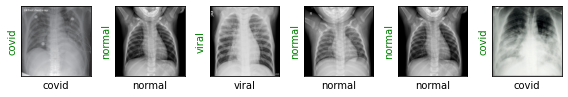

In [13]:
images , labels = next(iter(dl_validation))
show_images(images , labels , labels)
                       

In [14]:
resnet18 =  torchvision.models.resnet18(pretrained=True)
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [15]:
resnet18.fc  =  torch.nn.Linear(in_features=512 , out_features=3)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters() , lr=3e-5)

In [16]:
def show_preds():
    resnet18.eval() # Setting the model to evaluation mode
    images , labels = next(iter(dl_validation))
    outputs = resnet18(images)
    _ , preds  = torch.max(outputs , 1)
    show_images(images , labels , preds)
    
    

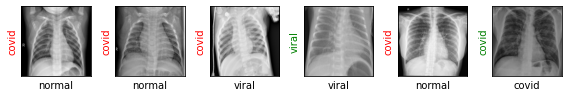

In [17]:
show_preds()

In [18]:
def train(epochs):
    print("Start training ... ")
    for e in range(0,epochs):
        print('='*20)
        print(f"Starting epoch {e+1}/{epochs}")
        print("="*20)
        
        
        train_loss = 0.
        val_loss = 0.
        
        resnet18.train() # Setting model to training phase
        
        for train_step , (images , labels)  in enumerate(dl_train):
            optimizer.zero_grad()
            outputs =  resnet18(images)
            loss = loss_fn(outputs , labels)
            loss.backward()# back propagation
            optimizer.step()# updating all the parameters
            train_loss += loss.item() # adding the loss value
            # we will evaluate our model in ever 20th step
            if train_step%20 ==0:
                print("Evaluating at step " , train_step)
                
                accuracy  = 0
                
                resnet18.eval()# set model to eval phase 
                
                for val_step , (images , labels)  in enumerate(dl_validation):
                        
                        outputs =  resnet18(images)
                        loss = loss_fn(outputs , labels)
                        val_loss +=  loss.item()
                        
                        _ , preds = torch.max(outputs , 1)
                        accuracy += sum((preds == labels).numpy())
               
                val_loss /=(val_step +1)
                accuracy /= len(validation_dataset)
                print(f"Validation loss : {val_loss:.4f} , Accuracy : {accuracy:.4f}")
                show_preds()
                resnet18.train()# setting into training phase again
                
                if accuracy >= 0.95 :
                    print("Performance condition satisfied , stopping ....")
                    return
                
        train_loss /= (train_step+1)
        print(f"Training Loss : {train_loss:.4f}")
            
print("Training Complete  ...")                
            
        

Training Complete  ...


Start training ... 
Starting epoch 1/1
Evaluating at step  0
Validation loss : 1.2351 , Accuracy : 0.3222


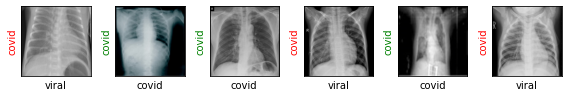

Evaluating at step  20
Validation loss : 0.6424 , Accuracy : 0.7333


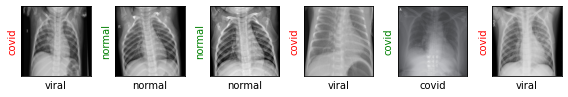

Evaluating at step  40
Validation loss : 0.5117 , Accuracy : 0.8000


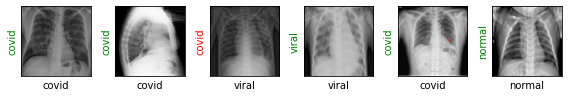

Evaluating at step  60
Validation loss : 0.2518 , Accuracy : 0.9444


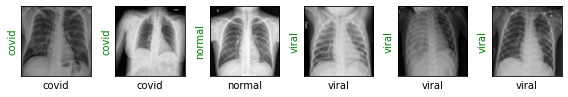

Evaluating at step  80
Validation loss : 0.1702 , Accuracy : 0.9556


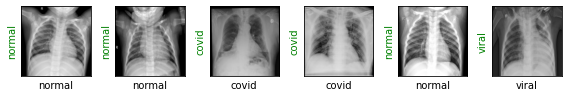

Performance condition satisfied , stopping ....


In [19]:
train(epochs =1)

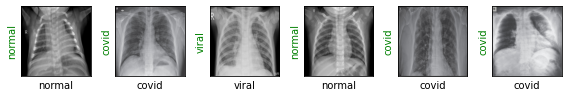

In [21]:
def show_preds():
    resnet18.eval()
    images , labels = next(iter(dl_test))
    outputs = resnet18(images)
    _ , preds  = torch.max(outputs , 1)
    show_images(images , labels , preds)
    
    
show_preds()